# #8 Kähler Manifolds as Curvature Frameworks for Dynamic Simulation
### By Saksham H.

In [44]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.fft import fft2, ifft2, fftfreq
from scipy.ndimage import gaussian_filter, maximum_filter
from scipy.linalg import expm

from qiskit.quantum_info import Statevector, state_fidelity

## 2D incompressible flow in vorticity form (toy example)

We simulate the 2D incompressible Euler equation in vorticity form:

$$\partial_t \omega + \{\psi,\omega\} = 0,
\qquad
\omega = \Delta \psi,$$

where the velocity is

$$\mathbf{u} = \nabla^\perp \psi = (\partial_y\psi,\; -\partial_x\psi),$$

and the Poisson bracket is

$$\{\psi,\omega\} = \partial_x\psi\,\partial_y\omega - \partial_y\psi\,\partial_x\omega.$$


This is Hamiltonian-like:
- conserved Casimirs $\int F(\omega)$
- area-preserving advection
- rich vortex interactions even in simple initial conditions.

In [99]:
def make_grid(N=128, L=2*np.pi):
    x = np.linspace(0, L, N, endpoint=False)
    y = np.linspace(0, L, N, endpoint=False)
    X, Y = np.meshgrid(x, y, indexing="ij")
    kx = fftfreq(N, d=L/N) * 2*np.pi
    ky = fftfreq(N, d=L/N) * 2*np.pi
    KX, KY = np.meshgrid(kx, ky, indexing="ij")
    K2 = KX**2 + KY**2
    K2[0,0] = 1.0 
    return X, Y, KX, KY, K2

def poisson_solve_vorticity_to_stream(omega, K2):
    omega_hat = fft2(omega)
    psi_hat = -omega_hat / K2
    psi_hat[0,0] = 0.0
    psi = np.real(ifft2(psi_hat))
    return psi

def grad_spectral(f, KX, KY):
    f_hat = fft2(f)
    fx = np.real(ifft2(1j*KX * f_hat))
    fy = np.real(ifft2(1j*KY * f_hat))
    return fx, fy

def euler_rhs(omega, KX, KY, K2, nu=1e-5, p=4):
    psi = poisson_solve_vorticity_to_stream(omega, K2)
    psix, psiy = grad_spectral(psi, KX, KY)
    omegax, omegay = grad_spectral(omega, KX, KY)

    adv = psix * omegay - psiy * omegax

    omega_hat = fft2(omega)
    diss_hat = -nu * (K2**p) * omega_hat
    diss = np.real(ifft2(diss_hat))

    return -adv + diss

def rk4_step(omega, dt, *rhs_args):
    k1 = euler_rhs(omega, *rhs_args)
    k2 = euler_rhs(omega + 0.5*dt*k1, *rhs_args)
    k3 = euler_rhs(omega + 0.5*dt*k2, *rhs_args)
    k4 = euler_rhs(omega + dt*k3, *rhs_args)
    return omega + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

def init_two_vortex_blobs(X, Y, L=2*np.pi):
    def gauss(x0, y0, s):
        return np.exp(-((X-x0)**2 + (Y-y0)**2)/(2*s**2))
    s = 0.25
    w =  6.0*gauss(1.8, 2.4, s) - 6.0*gauss(4.0, 3.6, s)
    w += 2.0*gauss(3.2, 1.4, 0.35)
    return w

In [100]:
N = 128
L = 2*np.pi
X, Y, KX, KY, K2 = make_grid(N, L)

def init_many_vortices(X, Y, L, n_vort=10, seed=0):
    
    #Initialize a sum of Gaussian vortex blobs with random positions, strengths, and signs.

    rng = np.random.default_rng(seed)
    omega = np.zeros_like(X)

    for _ in range(n_vort):
        x0 = rng.uniform(0, L)
        y0 = rng.uniform(0, L)
        strength = rng.uniform(0.5, 1.5) * rng.choice([-1, 1])
        sigma = rng.uniform(0.15, 0.35)

        r2 = (X - x0)**2 + (Y - y0)**2
        omega += strength * np.exp(-r2 / (2 * sigma**2))

    omega -= omega.mean()
    return omega

omega = init_many_vortices(X, Y, L=L, n_vort=10, seed=1)

dt = 0.002
snap_steps = [0, 1000, 2000]
steps = 3000
snaps = []

for s in range(steps+1):
    if s in snap_steps:
        snaps.append(omega.copy())
    omega = rk4_step(omega, dt, KX, KY, K2, 5e-6, 0)
    omega = np.nan_to_num(omega, nan=0.0, posinf=0.0, neginf=0.0)

print("Captured snapshots:", len(snaps))

Captured snapshots: 3


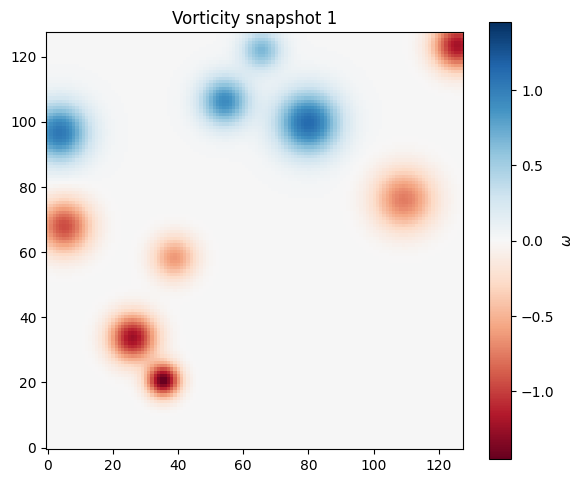

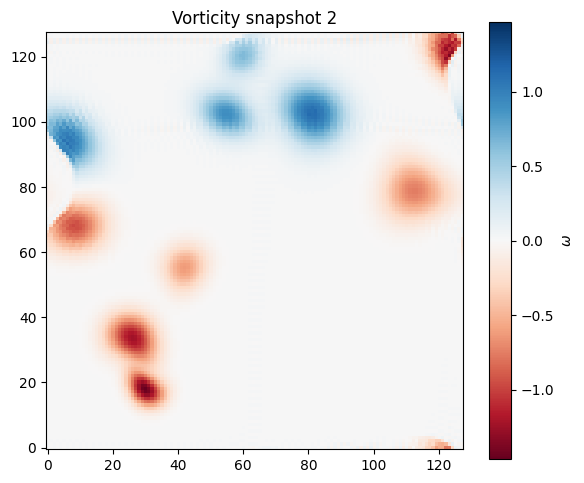

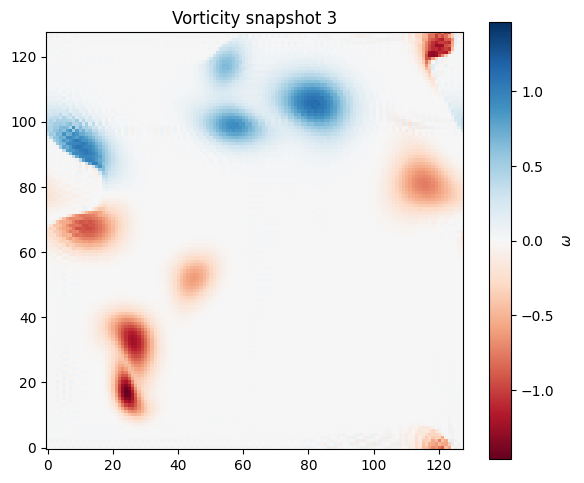

In [101]:
def plot_vorticity(omega, title="vorticity"):
    plt.figure(figsize=(6,5))

    vmax = np.max(np.abs(omega))
    if vmax == 0:
        vmax = 1e-8 

    plt.imshow(
        omega.T,
        origin="lower",
        cmap="RdBu",
        vmin=-vmax,
        vmax=+vmax
    )
    plt.colorbar(label=r"$\omega$")
    plt.title(title)
    plt.tight_layout()
    plt.show()

for i, w in enumerate(snaps):
    plot_vorticity(w, title=f"Vorticity snapshot {i+1}")

Note, red is positive vorticity (counterclockwise) and blue is negative vorticity (clockwise).

The lightening/smearing is mainly diffusion here.

This illustrates Hamiltonian and weakly dissipative dynamics in 2D, and although the model is relatively simple, it does have nonlinearity, sensitive conditions, and hidden geometric structure which we are focused on.

## Holomorphic "Bargmann-like" encoding from vortex cores

We extract a few dominant vortex core locations $z_k = x_k + i y_k$ from $\omega(x,y)$.
Then we build an entire function (a Bargmann proxy):

$$f(z) \;=\; e^{-\alpha z^2}\prod_{k=1}^{m}(z - z_k).$$

- The **zeros** $\{z_k\}$ are the discrete geometric data (stellar-style).
- The Gaussian factor is a nod to Bargmann/Fock space weighting (entire + controlled growth).
- Newton iteration

$$N_f(z) = z - \frac{f(z)}{f'(z)}$$

partitions the plane into basins → **Newton fractal**.

This gives a concrete pipeline:
fluid snapshot → vortex geometry → entire function → zeros → Newton fractal.

We have thus transitioned from classical dynamics to quantum states with a natural geometry among the fractal; this compatibility provides multiple perspectives to the same system.

In [ ]:
def extract_vortex_cores(omega, m=6, smooth_sigma=1.2):
    w = gaussian_filter(omega, smooth_sigma)
    a = np.abs(w)

    neigh = maximum_filter(a, size=7)
    mask = (a == neigh)

    coords = np.argwhere(mask)
    vals = a[mask]
    if len(vals) == 0:
        return np.array([]), np.array([])

    idx = np.argsort(vals)[::-1][:m]
    pts = coords[idx] 
    strengths = w[pts[:,0], pts[:,1]]  

    return pts, strengths

def grid_idx_to_complex(pts, L=2*np.pi, N=128):
    pts = np.asarray(pts)

    if pts.size == 0:
        return np.array([], dtype=np.complex128)

    pts = np.atleast_2d(pts)

    x = (pts[:, 0] / N) * L
    y = (pts[:, 1] / N) * L
    return x + 1j*y

def make_entire_function_from_zeros(zeros, alpha=0.015):
    zeros = np.array(zeros, dtype=np.complex128)

    def f(z):
        z = np.array(z, dtype=np.complex128)
        prod = np.ones_like(z)
        for zk in zeros:
            prod *= (z - zk)
        return np.exp(np.clip(-alpha * z*z, -50, 50)) * prod

    def fp(z):
        z = np.array(z, dtype=np.complex128)
        P = np.ones_like(z)
        for zk in zeros:
            P *= (z - zk)

        Pp = np.zeros_like(z)
        for k, zk in enumerate(zeros):
            term = np.ones_like(z)
            for j, zj in enumerate(zeros):
                if j != k:
                    term *= (z - zj)
            Pp += term

        return np.exp(np.clip(-alpha*z*z, -50, 50)) * (Pp - 2*alpha*z*P)

    return f, fp

In [ ]:
def newton_fractal(f, fp, xlim=(0, 2*np.pi), ylim=(0, 2*np.pi), res=500, iters=30, tol=1e-6):
    xs = np.linspace(xlim[0], xlim[1], res)
    ys = np.linspace(ylim[0], ylim[1], res)
    Z0 = xs[:,None] + 1j*ys[None,:]
    Z = Z0.copy()

    for _ in range(iters):
        denom = fp(Z)
        denom = np.where(np.abs(denom) < 1e-6, 1e-6, denom)
        eps = 1e-6
        denom = np.where(np.abs(denom) < eps, eps, denom)
        Z = Z - f(Z)/denom
        Z = np.nan_to_num(Z, nan=0.0, posinf=0.0, neginf=0.0)

    return Z0, Z

def assign_basins(Zfinal, zeros):
    zeros = np.array(zeros, dtype=np.complex128)
    if len(zeros) == 0:
        return None

    dists = np.stack([np.abs(Zfinal - zk) for zk in zeros], axis=0)
    labels = np.argmin(dists, axis=0)
    return labels

def plot_fractal(labels, zeros, title="Newton fractal"):
    plt.figure(figsize=(6,5))
    plt.imshow(labels.T, origin="lower", interpolation="nearest")
    plt.title(title)
    plt.colorbar(label="basin label")
    for zk in zeros:
        plt.scatter([zk.real * labels.shape[0]/(2*np.pi)],
                    [zk.imag * labels.shape[1]/(2*np.pi)],
                    s=40, edgecolor="k", facecolor="white")
    plt.tight_layout()
    plt.show()

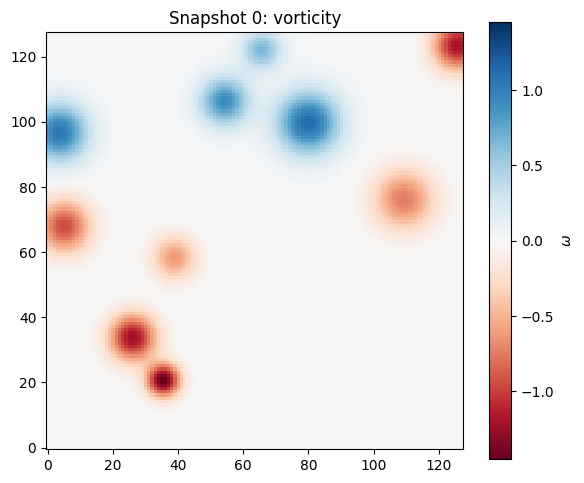

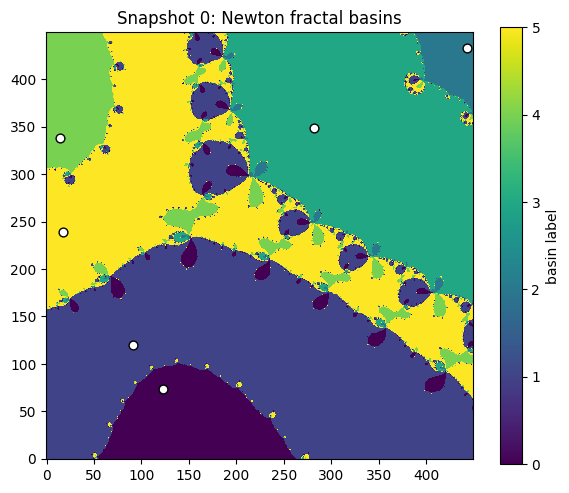

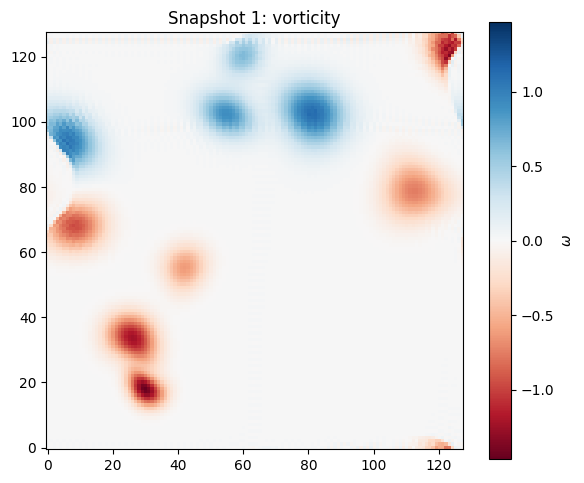

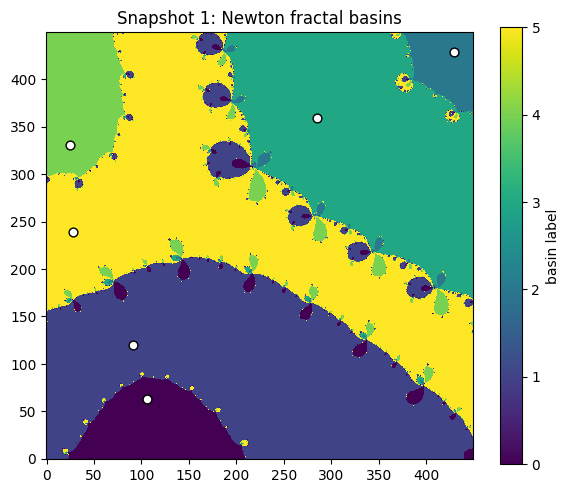

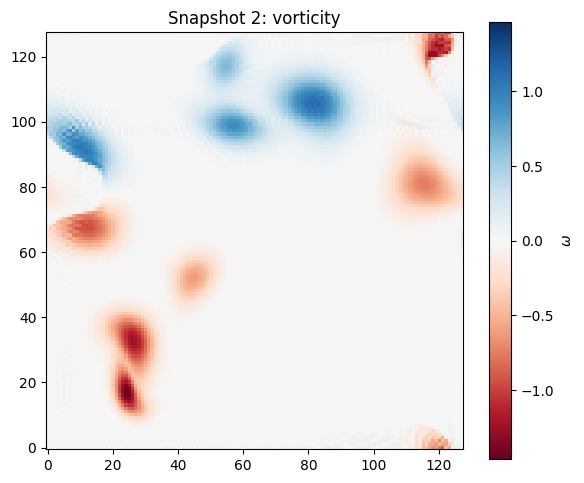

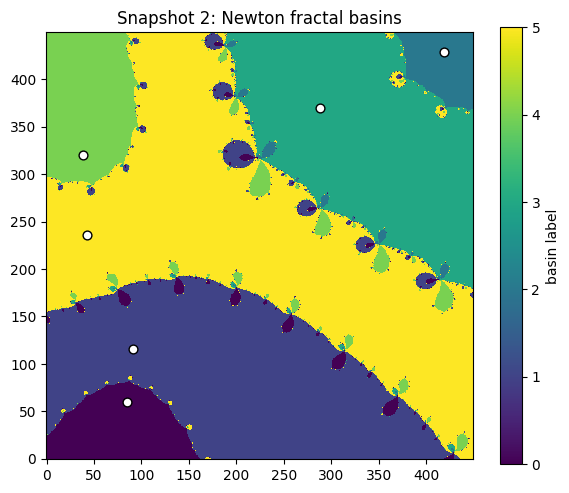

In [ ]:
snapshot_data = []

for i, w in enumerate(snaps):
    pts, strengths = extract_vortex_cores(w, m=6)

    if pts is None or len(pts) < 2:
        print(f"Snapshot {i+1}: insufficient vortices, skipping fractal.")
        plot_vorticity(w, title=f"Snapshot {i+1}: vorticity (no fractal)")
        continue

    zeros = grid_idx_to_complex(pts, L=L, N=N)

    f, fp = make_entire_function_from_zeros(zeros, alpha=0.01)
    Z0, Zfinal = newton_fractal(
        f, fp,
        xlim=(0, L), ylim=(0, L),
        res=450, iters=25
    )

    labels = assign_basins(Zfinal, zeros)

    if labels is None:
        print(f"Snapshot {i+1}: Newton iteration failed.")
        plot_vorticity(w, title=f"Snapshot {i+1}: vorticity (Newton failed)")
        continue

    snapshot_data.append({
        "omega": w,
        "zeros": zeros,
        "strengths": strengths,
        "labels": labels
    })

    plot_vorticity(w, title=f"Snapshot {i+1}: vorticity")
    plot_fractal(labels, zeros, title=f"Snapshot {i+1}: Newton fractal basins")

These fractals visually tell us a lot, and when our system becomes far more complicated, this framework provides a more geometric perspective where we can learn the behavior of such a system and extract moe information with this new access to various tools.

Here, observe
- the basins of attraction are the stable analytic regions
- the fractal boundaries are the "competition" among the zeroes
- the fracticality increases per snapshot

The point is that Newton fractals are geometric diagnostics that detect structure invisible to energy, probability, classical observables, and more.

## Qiskit step: encode holomorphic zero geometry into a quantum state

We take the zero set $\{z_k\}$ and produce a normalized amplitude vector:

$$a_k \propto e^{-|z_k|^2/(2\sigma^2)} \cdot e^{i\theta_k},
\quad
|\Psi\rangle = \sum_k a_k |k\rangle.$$

This is a *finite-dimensional compression* of the holomorphic state geometry:
- zeros $\Rightarrow$ discrete structure
- amplitudes $\Rightarrow$ a quantum state we can manipulate

Then we compare snapshots using:
- **fidelity** $F(|\psi\rangle,|\phi\rangle)=|\langle\psi|\phi\rangle|^2$
- **Fubini–Study distance**

$$d_{FS}(\psi,\phi)=\arccos|\langle\psi|\phi\rangle|.$$


This is the Kähler metric showing up in code.

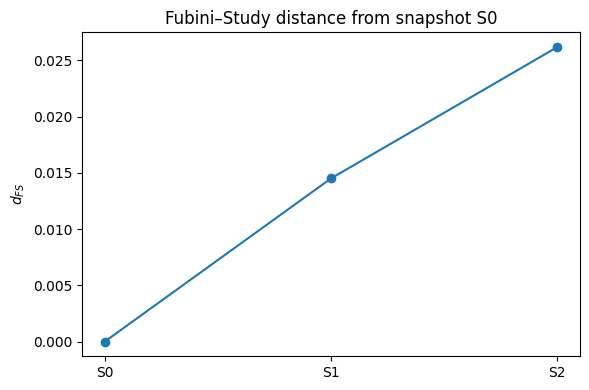

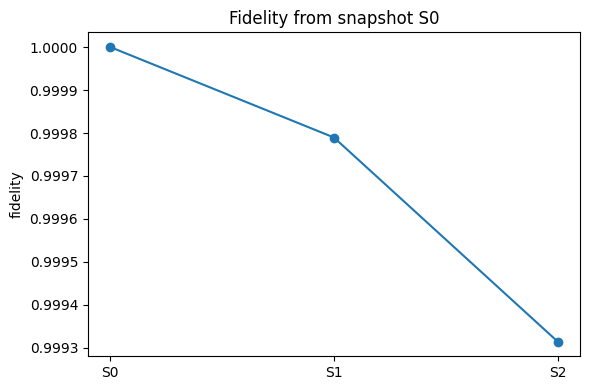

In [ ]:
def zeros_to_statevector(zeros, strengths, n_qubits=3, sigma=3.0):
    
    #Build 2^n complex amplitude vector from zeros and strengths.
    # - magnitude: Gaussian weight of |z|
    # - phase: sign/magnitude of vortex strength


    dim = 2**n_qubits
    m = min(len(zeros), dim)

    amps = np.zeros(dim, dtype=np.complex128)

    for k in range(m):
        zk = zeros[k]
        sk = strengths[k]
        mag = np.exp(-(np.abs(zk)**2)/(2*sigma**2))
        phase = np.exp(1j * 0.6 * sk) 
        amps[k] = mag * phase

    norm = np.linalg.norm(amps)
    if norm < 1e-12:
        amps[0] = 1.0
    else:
        amps /= norm

    return Statevector(amps)

def fubini_study_distance(sv1, sv2):
    overlap = np.abs(np.vdot(sv1.data, sv2.data))
    overlap = np.clip(overlap, 0.0, 1.0)
    return np.arccos(overlap)

states = []
for i, d in enumerate(snapshot_data):
    sv = zeros_to_statevector(d["zeros"], d["strengths"], n_qubits=3, sigma=6.0)
    states.append(sv)

dists = [fubini_study_distance(states[0], states[i]) for i in range(len(states))]
fids  = [state_fidelity(states[0], states[i]) for i in range(len(states))]

plt.figure(figsize=(6,4))
plt.plot(range(len(dists)), dists, marker="o")
plt.xticks(range(len(dists)), [f"S{i}" for i in range(len(dists))])
plt.ylabel(r"$d_{FS}$")
plt.title("Fubini–Study distance from snapshot S1")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(range(len(fids)), fids, marker="o")
plt.xticks(range(len(fids)), [f"S{i}" for i in range(len(fids))])
plt.ylabel("fidelity")
plt.title("Fidelity from snapshot S1")
plt.tight_layout()
plt.show()

Here, states move on a projective Hilbert space, where curvature drives evolution; not amplitude. This distance measures intrinsic distinguishability independent of basis, so the sensitivity is towards geometry and not measurement artifacts.

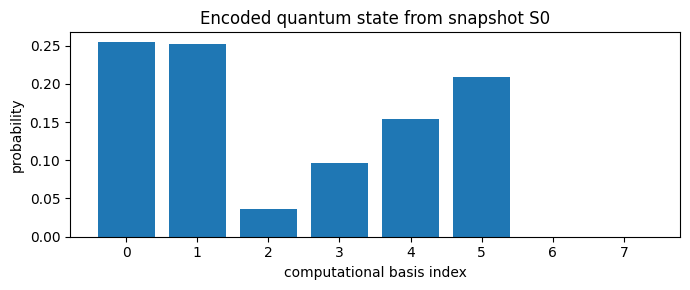

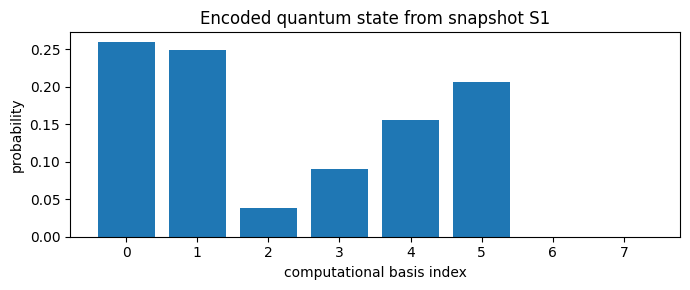

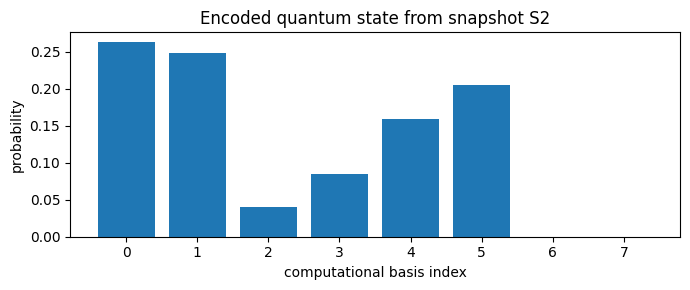

In [98]:
def plot_state_probs(sv, title="state probabilities"):
    probs = np.abs(sv.data)**2
    plt.figure(figsize=(7,3))
    plt.bar(range(len(probs)), probs)
    plt.xlabel("computational basis index")
    plt.ylabel("probability")
    plt.title(title)
    plt.tight_layout()
    plt.show()

for i, sv in enumerate(states):
    plot_state_probs(sv, title=f"Encoded quantum state from snapshot S{i}")

These probabilities are all the same; but that signifies the key takeaway here:

**geometry evolves even when probabilities don't.**